# Facial Action Unit Activations

## Prepare Data

In [1]:
from pathlib import Path
import numpy as np
import random
import tensorflow as tf


name_of_this_notebook = 'fau.ipynb'

BATCH_SIZE = 32
LR = 1e-3

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

experiment_name = f'batch-{BATCH_SIZE}-lr-{LR:.0e}'

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero-multimodal/facial_action_unit_activations')

2024-10-31 17:48:04.945555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 17:48:04.966576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 17:48:04.966594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 17:48:04.967167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 17:48:04.970812: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pandas as pd

train_df = pd.read_csv(str(dataset_path / 'training_set.csv'))
val_df = pd.read_csv(str(dataset_path / 'validation_set.csv'))
test_df = pd.read_csv(str(dataset_path / 'test_set.csv'))


def prepare_data(df):
    X = df.iloc[:, 2:-1].values  # All columns except timestamp, participant_id, and label
    y = df.iloc[:, -1].values  # The last column is the label
    return X, y


X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

In [3]:
import tensorflow as tf


def create_dataset(X, y, batch_size, reshuffle_each_iteration):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X), seed=SEED, reshuffle_each_iteration=reshuffle_each_iteration).batch(batch_size)
    return dataset


train_dataset = create_dataset(X_train, y_train, BATCH_SIZE, True)
val_dataset = create_dataset(X_val, y_val, BATCH_SIZE, False)
test_dataset = create_dataset(X_test, y_test, BATCH_SIZE, False)

2024-10-31 17:48:05.937944: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-31 17:48:05.937957: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: ubu-pcgh
2024-10-31 17:48:05.937959: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: ubu-pcgh
2024-10-31 17:48:05.938039: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-10-31 17:48:05.938046: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-10-31 17:48:05.938048: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


### Prepare Class Frequencies for Loss Function 

In [4]:
id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}

class_frequencies = train_df['Label'].value_counts()
print(f'--- Training Set Class Frequencies ---')
for class_id, frequency in class_frequencies.items():
    print(f'{class_id} - {id_to_emotion[class_id]:<9} : {frequency:>8}')

inverse_class_frequencies = 1 / class_frequencies
normalized_inverse_class_frequencies = inverse_class_frequencies / inverse_class_frequencies.sum()
class_weights = normalized_inverse_class_frequencies.to_dict()
print(f'\nClass Weights:\n {class_weights}')

--- Training Set Class Frequencies ---
0 - Neutral   :      197
1 - Happy     :      191
3 - Surprise  :      172
2 - Sad       :      131
4 - Fear      :      105
5 - Disgust   :      102
6 - Anger     :       66

Class Weights:
 {0: 0.08716123123128974, 1: 0.08989928037991667, 3: 0.09983001484048884, 2: 0.13107452330201588, 4: 0.16353107192918173, 5: 0.16834080933886353, 6: 0.26016306897824365}


## Define Network Architecture

In [5]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

fau_input = Input(shape=(63,), name='fau_input')
x = Dense(128, activation='relu')(fau_input)
x = Dropout(0.2, name='fau_dropout_1')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2, name='fau_dropout_2')(x)
fau_output = Dense(7, activation='softmax')(x)

fau_model = Model(inputs=fau_input, outputs=fau_output)
fau_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fau_input (InputLayer)      [(None, 63)]              0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 fau_dropout_1 (Dropout)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 fau_dropout_2 (Dropout)     (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 16903 (66.03 KB)
Trainable params: 16903 (66.03

## Train the Network

In [6]:
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

optimizer = Adam(learning_rate=LR)

timestamp = datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f'{timestamp}-checkpoint-{experiment_name}')
model_checkpoint_callback = ModelCheckpoint(filepath=f'{checkpoint_dir / "fau_model"}.keras',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=8, min_lr=1e-6)

callbacks = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

fau_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = fau_model.fit(train_dataset,
                        validation_data=val_dataset,
                        class_weight=class_weights,
                        callbacks=callbacks,
                        epochs=200)

Epoch 1/200
31/31 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.3558 - val_loss: 1.5907 - val_accuracy: 0.5870 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.6131 - val_loss: 1.1043 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1355 - accuracy: 0.7324 - val_loss: 0.8234 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1082 - accuracy: 0.7728 - val_loss: 0.7189 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0977 - accuracy: 0.7863 - val_loss: 0.6521 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0899 - accuracy: 0.7925 - val_loss: 0.6203 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 874us/step - loss: 0

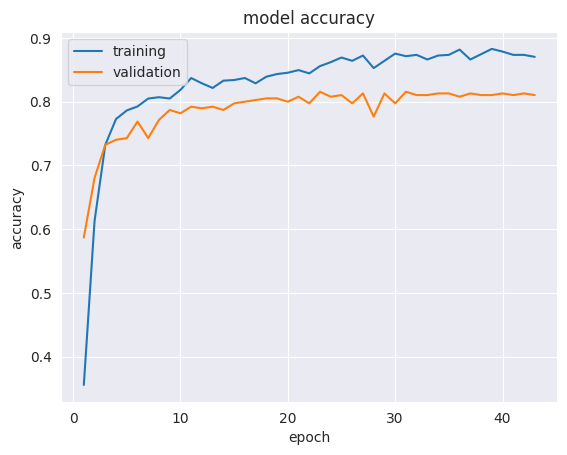

In [8]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hist, checkpoint_dir):
    acc = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(history, checkpoint_dir)

## Evaluate Model

In [9]:
from tensorflow.keras.models import load_model

best_checkpoint = str(checkpoint_dir / "fau_model.keras")
best_model = load_model(best_checkpoint)

In [10]:
val_loss, val_acc = best_model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc}\nValidation loss: {val_loss}")

13/13 [==============================] - 0s 692us/step - loss: 0.5205 - accuracy: 0.8156
Validation accuracy: 0.8155844211578369
Validation loss: 0.5204571485519409


In [11]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

12/12 [==============================] - 0s 775us/step - loss: 0.9676 - accuracy: 0.7169
Test accuracy: 0.7169312238693237


In [12]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = best_model.predict(test_dataset)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

12/12 [==============================] - 0s 618us/step
              precision    recall  f1-score   support

     Neutral     0.6923    0.8333    0.7563        54
       Happy     0.7910    0.9815    0.8760        54
         Sad     0.9231    0.6667    0.7742        54
    Surprise     0.7705    0.8704    0.8174        54
        Fear     0.6458    0.5741    0.6078        54
     Disgust     0.5410    0.6111    0.5739        54
       Anger     0.7027    0.4815    0.5714        54

    accuracy                         0.7169       378
   macro avg     0.7238    0.7169    0.7110       378
weighted avg     0.7238    0.7169    0.7110       378



[[45  2  1  0  5  1  0]
 [ 0 53  0  0  1  0  0]
 [ 8  0 36  0  2  1  7]
 [ 2  0  0 47  4  1  0]
 [ 6  3  0 11 31  3  0]
 [ 0  8  2  3  4 33  4]
 [ 4  1  0  0  1 22 26]]


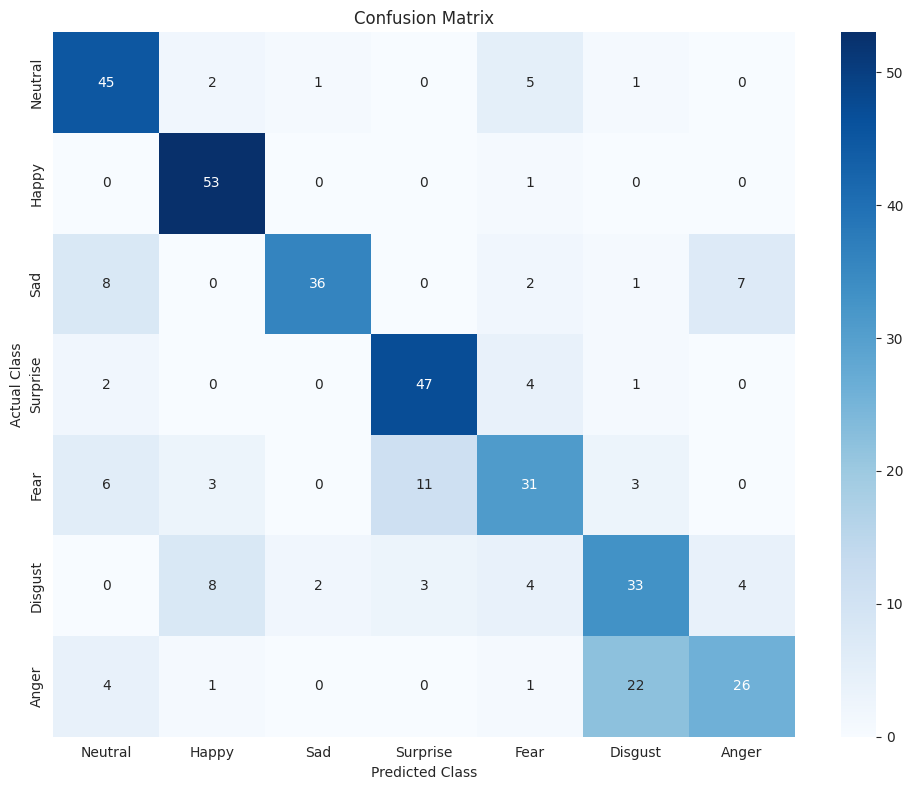

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)

In [14]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [15]:
import time

time.sleep(5)

In [16]:
def add_test_acc_to_checkpoint_dir_name(checkpoint_dir, val_acc, test_acc):
    new_name = checkpoint_dir.name + f'_val_{str(val_acc)[2:6]}_test_{str(test_acc)[2:6]}'
    new_path = checkpoint_dir.parent / new_name
    checkpoint_dir.rename(new_path)
    return new_path


new_checkpoint_dir = add_test_acc_to_checkpoint_dir_name(checkpoint_dir, val_acc, test_acc)

In [17]:
time.sleep(5)

In [18]:
import shutil

shutil.copy2((Path() / name_of_this_notebook), (new_checkpoint_dir / name_of_this_notebook))

PosixPath('20241031-1748-checkpoint-batch-32-lr-1e-03_val_8155_test_7169/fau.ipynb')